In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import rankdata

from singleVis.data import NormalDataProvider
epoch = 20


CONTENT_PATH = '/home/yifan/dataset/clean/pairflip/cifar10/0'
import sys
import os
import json
VIS_METHOD = 'DVI'

sys.path.append(CONTENT_PATH)
with open(os.path.join(CONTENT_PATH, "config.json"), "r") as f:
    config = json.load(f)
config = config[VIS_METHOD]
CLASSES = config["CLASSES"]

TRAINING_PARAMETER = config["TRAINING"]
NET = TRAINING_PARAMETER["NET"]

import Model.model as subject_model
net = eval("subject_model.{}()".format(NET))

data_provider = NormalDataProvider(CONTENT_PATH, net, epoch, epoch, 1, device='cuda:0', epoch_name='Epoch',classes=CLASSES,verbose=1)

/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Finish initialization...


In [3]:
from umap.umap_ import fuzzy_simplicial_set, make_epochs_per_sample
from pynndescent import NNDescent
from sklearn.utils import check_random_state

def _construct_fuzzy_complex(train_data, metric="euclidean"):
        # """
        # construct a vietoris-rips complex
        # """
        # number of trees in random projection forest
        n_trees = min(64, 5 + int(round((train_data.shape[0]) ** 0.5 / 20.0)))
        # max number of nearest neighbor iters to perform
        n_iters = max(5, int(round(np.log2(train_data.shape[0]))))
        # distance metric
        # # get nearest neighbors
        
        nnd = NNDescent(
            train_data,
            n_neighbors=15,
            metric=metric,
            n_trees=n_trees,
            n_iters=n_iters,
            max_candidates=60,
            verbose=True
        )
        knn_indices, knn_dists = nnd.neighbor_graph
        random_state = check_random_state(42)
        complex, sigmas, rhos = fuzzy_simplicial_set(
            X=train_data,
            n_neighbors=15,
            metric=metric,
            random_state=random_state,
            knn_indices=knn_indices,
            knn_dists=knn_dists
        )
        return complex, sigmas, rhos, knn_indices
train_data = data_provider.train_representation(epoch)
train_data = train_data.reshape(len(train_data), -1)
complex, sigmas, rhos, knn_indices = _construct_fuzzy_complex(train_data)

2024-01-19 22:09:27.797706: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-19 22:09:28.452773: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-19 22:09:28.452831: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-01-19 22:09:28.452836: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

Fri Jan 19 22:09:29 2024 Building RP forest with 16 trees
Fri Jan 19 22:09:30 2024 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	Stopping threshold met -- exiting after 5 iterations


In [4]:
from singleVis.backend import get_graph_elements, get_attention
VISUALIZATION_PARAMETER = config["VISUALIZATION"]
S_N_EPOCHS = VISUALIZATION_PARAMETER["S_N_EPOCHS"]

_, edge_to, edge_from, weight, _ = get_graph_elements(complex, S_N_EPOCHS)


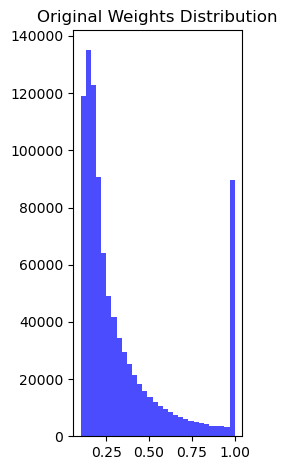

In [5]:
# 原始权重分布
plt.subplot(1, 3, 1)
plt.hist(weight, bins=30, color='blue', alpha=0.7)
plt.title("Original Weights Distribution")
plt.tight_layout()
plt.show()

In [6]:

# 计算每个独特数值的频率
values, counts = np.unique(weight, return_counts=True)
probabilities = counts / counts.sum()

# 计算期望值
expectation = np.sum(values * probabilities)

print(expectation)

0.3438932758388039


In [ ]:

d_ = (1 / _a ** (1 / (2 * _b))) * ((1 / expectation - 1) ** (1 / (2 * _b)))
print(d_)

Text(0.5, 1.0, 'Rank Transformed Distribution')

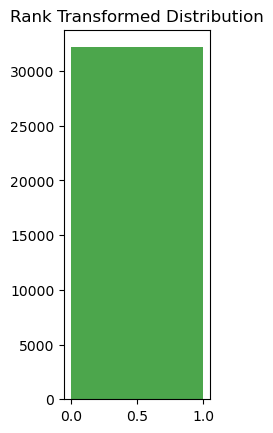

In [10]:
# 应用排名转换
rank_transformed_weights = rankdata(weight, method='average') / len(weight)
plt.subplot(1, 3, 2)
plt.hist(rank_transformed_weights, bins=30, color='green', alpha=0.7)
plt.title("Rank Transformed Distribution")

In [50]:


# 计算每个独特数值的频率
values, counts = np.unique(rank_transformed_weights, return_counts=True)
probabilities = counts / counts.sum()

# 计算期望值
expectation = np.sum(values * probabilities)

print(expectation)

0.5000005179908585


In [48]:
feature_vectors_pred = data_provider.get_pred(epoch, train_data)

100%|██████████| 250/250 [00:00<00:00, 425.32it/s]


Text(0.5, 1.0, 'Prediction semantics Distortion')

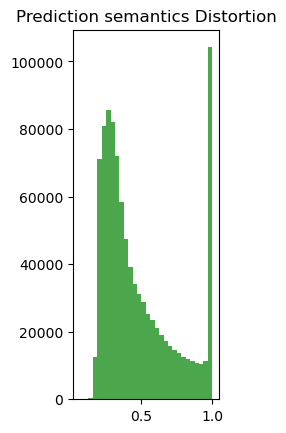

In [52]:
edge_to_pred = feature_vectors_pred[edge_to]
edge_from_pred = feature_vectors_pred[edge_from]
          
pred_similarity = np.einsum('ij,ij->i', edge_to_pred, edge_from_pred) / (np.linalg.norm(edge_to_pred, axis=1) * np.linalg.norm(edge_from_pred, axis=1))

# pred_probs = np.where(rank_transformed_weights == 1,1,np.where(pred_similarity < 0, rank_transformed_weights * (1 + pred_similarity), rank_transformed_weights + (1 - rank_transformed_weights) * rank_transformed_weights * pred_similarity))


pred_probs = np.where(weight == 1,1,np.where(pred_similarity < 0, weight * (1 + pred_similarity), weight + (1 - weight) * weight * pred_similarity))
            
plt.subplot(1, 3, 2)
plt.hist(pred_probs, bins=30, color='green', alpha=0.7)
plt.title("Prediction semantics Distortion")

In [57]:

# 计算每个独特数值的频率
values, counts = np.unique(pred_probs, return_counts=True)
probabilities = counts / counts.sum()

# 计算期望值
expectation = np.sum(values * probabilities)

print(expectation)

0.48537045873625645


In [59]:
from umap.umap_ import find_ab_params
min_dist = .1
_a, _b = find_ab_params(1.0, min_dist)

d_ = (1 / _a ** (1 / (2 * _b))) * ((1 / expectation - 1) ** (1 / (2 * _b)))
print(d_)


0.8011182663516885


965268
867994


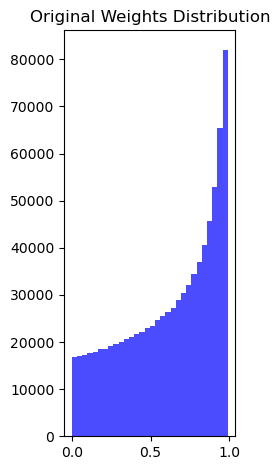

In [54]:
# 原始权重分布
weight = np.load('probs_for_epoch20.npy')
show_weight = np.load('pred_probs_for_epoch20.npy')
print(len(show_weight))
n_weight = show_weight[weight < 0.9]
print(len(n_weight))
plt.subplot(1, 3, 1)
plt.hist(n_weight, bins=30, color='blue', alpha=0.7)
plt.title("Original Weights Distribution")
plt.tight_layout()
plt.show()

In [55]:

# 计算每个独特数值的频率
values, counts = np.unique(n_weight, return_counts=True)
probabilities = counts / counts.sum()

# 计算期望值
expectation = np.sum(values * probabilities)

print(expectation)

0.6160963659501866


In [5]:
from umap.umap_ import find_ab_params
min_dist = .1
_a, _b = find_ab_params(1.0, min_dist)

# d_ = (1 / _a ** (1 / (2 * _b))) * ((1 / expectation - 1) ** (1 / (2 * _b)))


In [6]:
_a, _b

(1.5769434604035877, 0.8950608780665811)

In [1]:
from umap.umap_ import find_ab_params
min_dist = .1
_a, _b = find_ab_params(1.0, min_dist)

/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-01-20 21:37:42.712776: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-20 21:37:43.899981: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-20 21:37:43.900043: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinf

In [2]:
w = 1/ (1 + 0.1 ** (2*_b) * _a)

In [3]:
w

0.9750695587933784

In [15]:
from umap.umap_ import find_ab_params
min_dist = .1
_a, _b = find_ab_params(1.0, min_dist)

expectation = 0.04

d_ = (1 / _a ** (1 / (2 * _b))) * ((1 / expectation - 1) ** (1 / (2 * _b)))
print(d_)

4.576263304051438


In [13]:
d_

3.60607707265276

In [ ]:
import math
attraction_term = - 0.9 * math.log(1/0.5)
repellent_term = -(1.0 - 0.9)* math.log()
